# Set Up

In [26]:
!pip install category_encoders -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.7 MB/s eta 0:00:00


In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import datetime as dt
import category_encoders as ce
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
# load dataset (csv) into pandas dataframe
df = pd.read_csv("/content/legit_customer_sample.csv")

# Exploratory Data Analysis

In [3]:
# show the sample of data in the dataframe
df.sample(3)

,trx_date,trx_date_detail,sales_id,concept,brand,outlet,district,city,menu_id,menu_type,menu_category,menu_category_detail,menu_name,quantity,user_id,user_created_at,user_tier_level,user_gender
15002,2023-01-01,2023-01-01 15:24:35 UTC,f93f6813-ea7e-4915-a94f-f0cccc837b38,Resto,Kitchenette,"Kitchenette, Gandaria City",Kebayoran Lama,Jakarta Selatan,ba8a4fd6-0863-469b-97ff-fcf7738ab76c,Package Head,BEVERAGE,WATER & SOFTDRINKS,Aqua Reflection,1.0,70c072d5-7ff1-4e78-a207-ec7ec0088a8c,2021-06-08 06:11:44,Basic,M
20420,2023-01-01,2023-01-01 14:47:09 UTC,b631a2d1-bb9b-4022-bc47-bb0906918d7a,Lifestyle,Osteria GIA,"Osteria GIA, Plaza Indonesia",Menteng,Jakarta Pusat,f161697c-a54d-4d3e-a771-994654caced9,Ala Carte,FOOD,PIZZA,Prosciutto e Funghi,1.0,f24df33c-85b7-4315-97d5-6a149ddf7e39,2023-01-01 07:55:50,Basic,F
932,2023-03-10,2023-03-11 02:09:00 UTC,f997883c-1ea7-49a7-a041-f9fbc7872bff,Lifestyle,DF Kitchen,"DF Kitchen, Gatot Subroto",Setia Budi,Jakarta Selatan,a2f7299e-5b90-4958-ac13-7e38b317a75e,Package Content,BEVERAGE,WATER & SOFTIES,Green Tea Pokka Carafe,1.0,7b9b2156-78c1-4d38-836d-cbe097fdfee8,2021-04-07 13:39:05,Diamond,F


In [4]:
# show the high-level overview of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26804 entries, 0 to 26803
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   trx_date              26804 non-null  object 
 1   trx_date_detail       26804 non-null  object 
 2   sales_id              26804 non-null  object 
 3   concept               26804 non-null  object 
 4   brand                 26804 non-null  object 
 5   outlet                26804 non-null  object 
 6   district              26804 non-null  object 
 7   city                  26804 non-null  object 
 8   menu_id               26804 non-null  object 
 9   menu_type             26804 non-null  object 
 10  menu_category         26804 non-null  object 
 11  menu_category_detail  26804 non-null  object 
 12  menu_name             26804 non-null  object 
 13  quantity              26804 non-null  float64
 14  user_id               26804 non-null  object 
 15  user_created_at    

## Numerical data

In [5]:
# display the descriptive statistics of all numerical data
df.describe()

,quantity
count,26804.000000
mean,1.163520
std,0.580635
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,16.000000


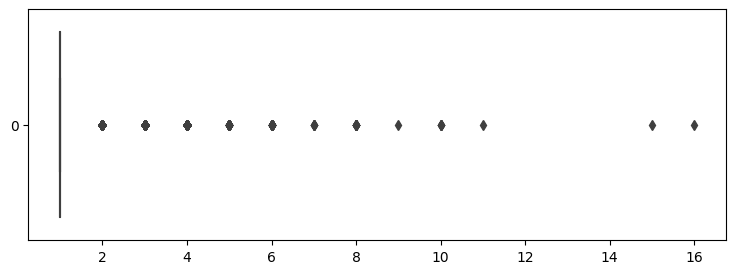

In [6]:
plt.figure(figsize=(9,3))
sns.boxplot(data=df['quantity'], orient='h')
plt.show()

## Categorical data

In [7]:
# display the descriptive statistics of all categorical data (1)
# since there are lots of columns, the display will be seperated
df.describe(include='object').iloc[:, :8]

,trx_date,trx_date_detail,sales_id,concept,brand,outlet,district,city
count,26804,26804,26804,26804,26804,26804,26804,26804
unique,90,4332,4362,2,16,100,30,13
top,2023-01-01,2023-01-01 12:54:19 UTC,e89b8641-40fc-4783-ba43-4bf06db1635f,Resto,Djournal,"Osteria GIA, Plaza Indonesia",Menteng,Jakarta Selatan
freq,8520,129,129,19073,8208,1705,5008,9748


In [8]:
# display the descriptive statistics of all categorical data (2)
# since there are lots of columns, the display will be seperated
df.describe(include='object').iloc[:, 8:]

,menu_id,menu_type,menu_category,menu_category_detail,menu_name,user_id,user_created_at,user_tier_level,user_gender
count,26804,26804,26804,26804,26804,26804,26804,26804,26804
unique,2520,3,7,96,2030,1000,873,5,2
top,c482f57f-68ae-4f9b-b1a1-cd4c005279fc,Ala Carte,BEVERAGE,ESPRESSO BASED,Kopi Susu Batavia,49444c7e-8d84-4d57-ab95-108ef3dc386e,2022-04-19 19:20:59,Basic,F
freq,549,10666,14053,2874,549,729,1528,9125,15382


In [9]:
# Distribution of FnB Concept
fig = px.pie(df, names="concept", width=400, height=400)
fig.update_layout(margin=dict(t=20, b=0))

In [10]:
# Distribution of Brand
fig = px.histogram(df, y="brand", width=800, height=400)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

In [11]:
# Distribution of City
fig = px.histogram(df, y="city", width=800, height=400)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

In [12]:
# Distribution of Menu Type
fig = px.pie(df, names="menu_type", width=400, height=400)
fig.update_layout(margin=dict(t=20, b=0))

In [13]:
# Distribution of Menu Category
fig = px.histogram(df, y="menu_category", width=800, height=400)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

In [14]:
# Distribution of Top 10 Menu Category Detail
freq_table = pd.crosstab(df['menu_category_detail'], '%_of_menu_category_detail')
freq_table = freq_table/len(df)
freq_table.sort_values('%_of_menu_category_detail', ascending=False)[:10]

col_0,%_of_menu_category_detail
menu_category_detail,
ESPRESSO BASED,0.107223
BEVERAGE MODIFIER,0.093083
KOPI BATAVIA BY DJOURNAL,0.069169
FOOD MODIFIER,0.067751
TEA,0.051858
PASTA,0.046299
FOOD ADDITIONAL,0.043725
TEA & COFFEE,0.041785
RICE & NOODLE,0.037942


In [15]:
# Distribution of Menu Category
fig = px.histogram(df, y="user_tier_level", width=800, height=400)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

In [16]:
# Distribution of User Gender
fig = px.pie(df, names="user_gender", width=400, height=400, color_discrete_sequence=["red", "blue"])
fig.update_layout(margin=dict(t=20, b=0))

# Data Preparation

## Data cleansing

In [17]:
df_clean = df.copy()

In [18]:
# check the amount of missing values (based on rows)
droprow_strategy = df.dropna()
print("Number of row(s) WITH missing values: %d" % (df.shape[0]))
print("Number of row(s) WITHOUT missing values: %d" % (droprow_strategy.shape[0]))
print("Percentage of missing values in the dataset: %.2f" % ((df.shape[0] - droprow_strategy.shape[0])/df.shape[0]*100))

Number of row(s) WITH missing values: 26804
Number of row(s) WITHOUT missing values: 26804
Percentage of missing values in the dataset: 0.00


In [19]:
def outlier_percentage(dataframe):
  Q1 = dataframe.quantile(0.25)
  Q3 = dataframe.quantile(0.75)
  IQR = Q3 - Q1
  RLB = Q1 - 1.5 * IQR
  RUB = Q3 + 1.5 * IQR
  return ((dataframe < RLB) | (dataframe > RUB)).sum()/dataframe.count()*100

In [20]:
# counting the percentage of outlier in each column
outlier_percentage(df_clean.select_dtypes(include='number'))

quantity    10.91255
dtype: float64

> I assume that if the outlier that present on a column is >=1%, it is indeed a real value recorded and is not an error from observation. Therefore, I don't have to handle those outliers.

> Based on the EDA steps, the maximum value of `quantity` data that is considered as an outlier are still logical (only 16)

In [21]:
# check whether there are duplicated row in the dataframe
df_clean.duplicated().sum()

1416

In [22]:
# drop duplicated row
df_clean.drop_duplicates(inplace=True, ignore_index=True)

In [49]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25388 entries, 0 to 25387
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   trx_date              25388 non-null  object 
 1   trx_date_detail       25388 non-null  object 
 2   sales_id              25388 non-null  object 
 3   concept               25388 non-null  object 
 4   brand                 25388 non-null  object 
 5   outlet                25388 non-null  object 
 6   district              25388 non-null  object 
 7   city                  25388 non-null  object 
 8   menu_id               25388 non-null  object 
 9   menu_type             25388 non-null  object 
 10  menu_category         25388 non-null  object 
 11  menu_category_detail  25388 non-null  object 
 12  menu_name             25388 non-null  object 
 13  quantity              25388 non-null  float64
 14  user_id               25388 non-null  object 
 15  user_created_at    

In [48]:
df_clean.sample()

,trx_date,trx_date_detail,sales_id,concept,brand,outlet,district,city,menu_id,menu_type,menu_category,menu_category_detail,menu_name,quantity,user_id,user_created_at,user_tier_level,user_gender
6465,2023-01-21,2023-01-21 21:30:27 UTC,a3a0bdec-8cbd-4c5b-a329-b169fbaa0292,Resto,Djournal,"Djournal, Grand Indonesia",Tanah Abang,Jakarta Pusat,c482f57f-68ae-4f9b-b1a1-cd4c005279fc,Package Head,BEVERAGE,KOPI BATAVIA BY DJOURNAL,Kopi Susu Batavia,1.0,57d1faa2-4745-48e9-9749-1071ec6eeba6,2021-04-18 06:44:50,Silver,F


> Up until here the dataset has been cleaned. The size of row has been reduced from 26.804 to 25.388

## Feature engineering
This steps is intended to select which column to be further processed in modeling steps. I also engineer new columns when needed. I hope that this approach will increase the clustering quality.

In [76]:
df_engineered = df_clean.copy()

In [77]:
# how long they've been our user?
df_engineered["customer_for_x_years"] = dt.datetime.now().year - pd.to_datetime(df_engineered["user_created_at"]).dt.year
df_engineered["customer_for_x_years"].value_counts()

2    13663
1    10586
0     1139
Name: customer_for_x_years, dtype: int64

> I assume that a user's account will be created the first time they order our service

In [78]:
# how many transaction (order) have a customer (user) made?
df_engineered["users_order_freq"] = ce.CountEncoder().fit_transform(df_engineered["user_id"])
df_engineered["users_order_freq"].describe()

count    25388.000000
mean        94.753348
std        142.084983
min          1.000000
25%         20.000000
50%         44.000000
75%        100.000000
max        707.000000
Name: users_order_freq, dtype: float64

In [79]:
# what kind of things do they order?
df_engineered["menu_category_detail_full"] = df_engineered["menu_category"] + " - " + df_engineered["menu_category_detail"]
df_engineered["menu_category_detail_full"].value_counts()

BEVERAGE - ESPRESSO BASED              2804
BEVERAGE - BEVERAGE MODIFIER           2141
BEVERAGE - KOPI BATAVIA BY DJOURNAL    1765
FOOD - FOOD MODIFIER                   1608
BEVERAGE - TEA                         1270
                                       ... 
FOOD - TEISHOKU                           1
OTHER - MERCHANDISE                       1
LIQUEUR - COCKTAIL BEER                   1
BEER - COCKTAIL BEER                      1
FOOD - NIGIRI                             1
Name: menu_category_detail_full, Length: 97, dtype: int64

In [88]:
# in which province does our outlet located?
city_province_mapping = {"Surabaya":"Jawa Timur",
                         "Bandung, Kota":"Jawa Barat",
                         "Denpasar":"Bali",
                         "Badung":"Bali"}
df_engineered = df_engineered.assign(province=df_engineered.city.map(city_province_mapping))
df_engineered['province'].fillna("Jabodetabek", inplace=True)
df_engineered['province'].value_counts()

Jabodetabek    21690
Jawa Timur      1989
Jawa Barat      1117
Bali             592
Name: province, dtype: int64

> Special treatment for city that are located on "Jabodetabek" area. Jabodetabek which is an agglomerated urban area will be treated as a province.

In [93]:
df_engineered.head()

,trx_date,trx_date_detail,sales_id,concept,brand,outlet,district,city,menu_id,menu_type,...,menu_name,quantity,user_id,user_created_at,user_tier_level,user_gender,customer_for_x_years,users_order_freq,menu_category_detail_full,province
0,2023-01-04,2023-01-04 20:26:46 UTC,02d6de17-9ca4-480f-b13c-7336dccd64b9,Lifestyle,A/A,"Apothecary, Gunawarman",Kebayoran Baru,Jakarta Selatan,5204e17e-aefb-4235-8eb8-7177a5679352,Ala Carte,...,French Fries,1.0,db0df3a5-2d00-4fed-93b1-99ea1eedccd8,2021-05-13 07:41:27,Gold,F,2,84,FOOD - APPETIZERS,Jabodetabek
1,2023-01-04,2023-01-04 20:26:46 UTC,02d6de17-9ca4-480f-b13c-7336dccd64b9,Lifestyle,A/A,"Apothecary, Gunawarman",Kebayoran Baru,Jakarta Selatan,1420bcef-ac34-4967-b5e0-4a2942f222a4,Package Content,...,Single,1.0,db0df3a5-2d00-4fed-93b1-99ea1eedccd8,2021-05-13 07:41:27,Gold,F,2,84,BEVERAGE - BEVERAGE MODIFIER,Jabodetabek
2,2023-01-04,2023-01-04 20:26:46 UTC,02d6de17-9ca4-480f-b13c-7336dccd64b9,Lifestyle,A/A,"Apothecary, Gunawarman",Kebayoran Baru,Jakarta Selatan,77bb78c6-2f51-4f61-9d74-02d69388cef1,Package Content,...,Coca Cola,1.0,db0df3a5-2d00-4fed-93b1-99ea1eedccd8,2021-05-13 07:41:27,Gold,F,2,84,BEVERAGE - BEVERAGE MODIFIER,Jabodetabek
3,2023-01-04,2023-01-04 20:26:46 UTC,02d6de17-9ca4-480f-b13c-7336dccd64b9,Lifestyle,A/A,"Apothecary, Gunawarman",Kebayoran Baru,Jakarta Selatan,f026874c-5a66-4184-8ce0-9aeb9e37b5ac,Package Content,...,Monkey Shoulder_Double,1.0,db0df3a5-2d00-4fed-93b1-99ea1eedccd8,2021-05-13 07:41:27,Gold,F,2,84,LIQUEUR - WHISK(E)Y,Jabodetabek
4,2023-01-04,2023-01-04 20:26:46 UTC,02d6de17-9ca4-480f-b13c-7336dccd64b9,Lifestyle,A/A,"Apothecary, Gunawarman",Kebayoran Baru,Jakarta Selatan,cfa23fc2-c4ab-4377-b0fe-489493016af1,Package Head,...,Lagavulin 16 YO (Glass),1.0,db0df3a5-2d00-4fed-93b1-99ea1eedccd8,2021-05-13 07:41:27,Gold,F,2,84,LIQUEUR - SINGLE MALT,Jabodetabek


In [94]:
df_engineered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25388 entries, 0 to 25387
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   trx_date                   25388 non-null  object 
 1   trx_date_detail            25388 non-null  object 
 2   sales_id                   25388 non-null  object 
 3   concept                    25388 non-null  object 
 4   brand                      25388 non-null  object 
 5   outlet                     25388 non-null  object 
 6   district                   25388 non-null  object 
 7   city                       25388 non-null  object 
 8   menu_id                    25388 non-null  object 
 9   menu_type                  25388 non-null  object 
 10  menu_category              25388 non-null  object 
 11  menu_category_detail       25388 non-null  object 
 12  menu_name                  25388 non-null  object 
 13  quantity                   25388 non-null  flo

In [95]:
# dataset for modeling the cluster
to_be_dropped = ["trx_date", "trx_date_detail", "sales_id",
                 "brand", "outlet", "district", "city",
                 "menu_id", "menu_type", "menu_category_detail", "menu_name",
                 "user_id", "user_created_at",
                 "menu_category_detail_full"]
df_for_modeling = df_engineered.drop(to_be_dropped, axis=1)
df_for_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25388 entries, 0 to 25387
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   concept               25388 non-null  object 
 1   menu_category         25388 non-null  object 
 2   quantity              25388 non-null  float64
 3   user_tier_level       25388 non-null  object 
 4   user_gender           25388 non-null  object 
 5   customer_for_x_years  25388 non-null  int64  
 6   users_order_freq      25388 non-null  int64  
 7   province              25388 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 1.5+ MB


In [172]:
# dataset for analysing the cluster
to_be_dropped = ["trx_date", "trx_date_detail",
                 "outlet", "district", "city",
                 "menu_id", "menu_type", "menu_category_detail",
                 "user_created_at"]
df_for_analysis = df_engineered.drop(to_be_dropped, axis=1)
df_for_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25388 entries, 0 to 25387
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sales_id                   25388 non-null  object 
 1   concept                    25388 non-null  object 
 2   brand                      25388 non-null  object 
 3   menu_category              25388 non-null  object 
 4   menu_name                  25388 non-null  object 
 5   quantity                   25388 non-null  float64
 6   user_id                    25388 non-null  object 
 7   user_tier_level            25388 non-null  object 
 8   user_gender                25388 non-null  object 
 9   customer_for_x_years       25388 non-null  int64  
 10  users_order_freq           25388 non-null  int64  
 11  menu_category_detail_full  25388 non-null  object 
 12  province                   25388 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usa

# Modeling

## Standardize numerical data

In [105]:
df_for_modeling.describe()

,quantity,customer_for_x_years,users_order_freq
count,25388.000000,25388.000000,25388.000000
mean,1.169096,1.493304,94.753348
std,0.588056,0.582834,142.084983
min,1.000000,0.000000,1.000000
25%,1.000000,1.000000,20.000000
50%,1.000000,2.000000,44.000000
75%,1.000000,2.000000,100.000000
max,16.000000,2.000000,707.000000


> Numerical attributes that was measured with different scales can cause bias when further processed in modelling phase. Therefore, it is better to standardize (scaled) those number. The technique that I will use is RobustScaler from SKLearn because this dataset contains some outlier. Further info: https://scikit-learn.org/stable/modules/preprocessing.html#scaling-data-with-outliers

In [99]:
numerical_data = df_for_modeling.select_dtypes(include='number')
numerical_data.head()

,quantity,customer_for_x_years,users_order_freq
0,1.0,2,84
1,1.0,2,84
2,1.0,2,84
3,1.0,2,84
4,1.0,2,84


In [101]:
df_robust_scaled = pd.DataFrame()
df_robust_scaled[numerical_data.columns] = RobustScaler().fit_transform(df_for_modeling.select_dtypes(include='number'))
display(df_robust_scaled)

,quantity,customer_for_x_years,users_order_freq
0,0.0,0.0,0.500
1,0.0,0.0,0.500
2,0.0,0.0,0.500
3,0.0,0.0,0.500
4,0.0,0.0,0.500
...,...,...,...
25383,0.0,0.0,-0.475
25384,0.0,0.0,-0.475
25385,0.0,0.0,-0.475
25386,0.0,0.0,-0.475


## Encode categorical data

In [106]:
df_for_modeling.describe(include=object)

,concept,menu_category,user_tier_level,user_gender,province
count,25388,25388,25388,25388,25388
unique,2,7,5,2,4
top,Resto,BEVERAGE,Basic,F,Jabodetabek
freq,17867,13163,8631,14506,21690


> Categorical attributes should be encoded into numeric value before it can be passed on to modeling steps with SKLearn.

I will encode some of the columns using one-hot strategy if there is no order between the categories

In [114]:
categorical_data = df_for_modeling.select_dtypes(exclude='number')
categorical_data.drop('user_tier_level', axis=1, inplace=True)
categorical_data.head()

,concept,menu_category,user_gender,province
0,Lifestyle,FOOD,F,Jabodetabek
1,Lifestyle,BEVERAGE,F,Jabodetabek
2,Lifestyle,BEVERAGE,F,Jabodetabek
3,Lifestyle,LIQUEUR,F,Jabodetabek
4,Lifestyle,LIQUEUR,F,Jabodetabek


In [115]:
encoder = OneHotEncoder(sparse_output=False)
temp = encoder.fit_transform(categorical_data)
df_encoded = pd.DataFrame(temp)
df_encoded.columns = encoder.get_feature_names_out()
df_encoded

,concept_Lifestyle,concept_Resto,menu_category_BEER,menu_category_BEVERAGE,menu_category_CIGARETTE,menu_category_FOOD,menu_category_LIQUEUR,menu_category_OTHER,menu_category_WINE,user_gender_F,user_gender_M,province_Bali,province_Jabodetabek,province_Jawa Barat,province_Jawa Timur
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25383,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
25384,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
25385,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
25386,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


I will encode some of the columns using ordinal strategy if there is an order between the categories

In [118]:
categorical_data_2 = df_for_modeling[['user_tier_level']]
categorical_data_2.value_counts()

user_tier_level
Basic              8631
Silver             7534
Diamond            5644
Gold               3072
Black               507
dtype: int64

> I assume that the tier levelling is linear with the number of user that has it

In [119]:
encoder = OrdinalEncoder(categories=[['Basic', 'Silver', 'Diamond', 'Gold', 'Black']])
temp = encoder.fit_transform(categorical_data_2)
df_encoded_2 = pd.DataFrame(temp)
df_encoded_2.columns = encoder.get_feature_names_out()
df_encoded_2

,user_tier_level
0,3.0
1,3.0
2,3.0
3,3.0
4,3.0
...,...
25383,0.0
25384,0.0
25385,0.0
25386,0.0


## Dimensionality reduction

In [122]:
# concatenate numerical & categorical column from previous steps
feature = pd.concat([df_robust_scaled, df_encoded, df_encoded_2], axis=1)

In [123]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25388 entries, 0 to 25387
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   quantity                 25388 non-null  float64
 1   customer_for_x_years     25388 non-null  float64
 2   users_order_freq         25388 non-null  float64
 3   concept_Lifestyle        25388 non-null  float64
 4   concept_Resto            25388 non-null  float64
 5   menu_category_BEER       25388 non-null  float64
 6   menu_category_BEVERAGE   25388 non-null  float64
 7   menu_category_CIGARETTE  25388 non-null  float64
 8   menu_category_FOOD       25388 non-null  float64
 9   menu_category_LIQUEUR    25388 non-null  float64
 10  menu_category_OTHER      25388 non-null  float64
 11  menu_category_WINE       25388 non-null  float64
 12  user_gender_F            25388 non-null  float64
 13  user_gender_M            25388 non-null  float64
 14  province_Bali         

To avoid curse of dimensionality phenomenon, I'll do a dimensionality reduction. First of all, I'm going to conduct PCA to decide the new desired dimension.

In [124]:
pca = PCA(n_components=12) # limit to 12 for visualization purpose
temp = pca.fit_transform(feature)

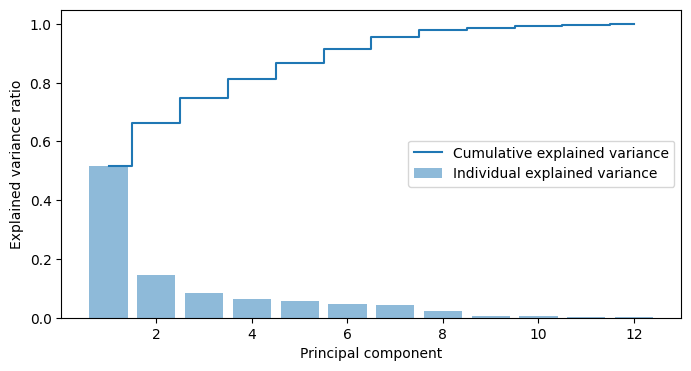

In [125]:
explained_variance_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(explained_variance_pca)

plt.figure(figsize=(8,4))
plt.bar(range(1,len(explained_variance_pca)+1), explained_variance_pca, alpha=0.5, label='Individual explained variance')
plt.step(range(1,len(explained_variance_pca)+1), cum_sum_eigenvalues, where= 'mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.show()

> Based on the above result, I will try to use 3 components.

In [126]:
n_components = 3
pca = PCA(n_components)
df_pca_3 = pd.DataFrame(pca.fit_transform(feature), columns=range(1, n_components+1))
df_pca_3

,1,2,3
0,0.280897,1.909636,1.257681
1,0.360791,1.881784,0.322423
2,0.360791,1.881784,0.322423
3,0.318324,1.928980,0.819701
4,0.318324,1.928980,0.819701
...,...,...,...
25383,-1.477077,-0.706367,0.384652
25384,-1.477077,-0.706367,0.384652
25385,-1.397183,-0.734219,-0.550606
25386,-1.397183,-0.734219,-0.550606


## Deciding the optimum number of cluster/segment

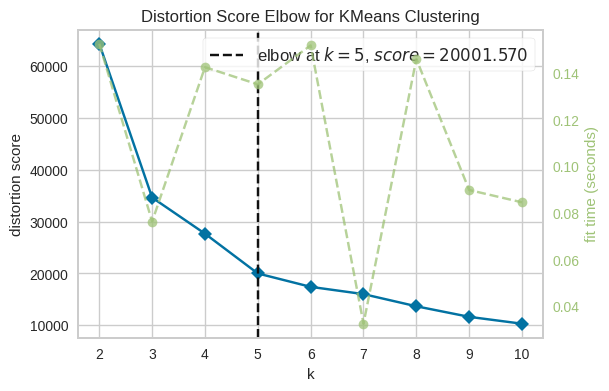

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [128]:
# elbow method
plt.figure(figsize=(6,4))
Elbow_M = KElbowVisualizer(KMeans(n_init='auto'), k=10)
Elbow_M.fit(df_pca_3)
Elbow_M.show()

For n_clusters = 2 The average silhouette_score is : 0.7197501283915612
For n_clusters = 3 The average silhouette_score is : 0.4756620196142289
For n_clusters = 4 The average silhouette_score is : 0.376894789752368
For n_clusters = 5 The average silhouette_score is : 0.40598221444018273
For n_clusters = 6 The average silhouette_score is : 0.3948321011057425
For n_clusters = 7 The average silhouette_score is : 0.38351684489921706


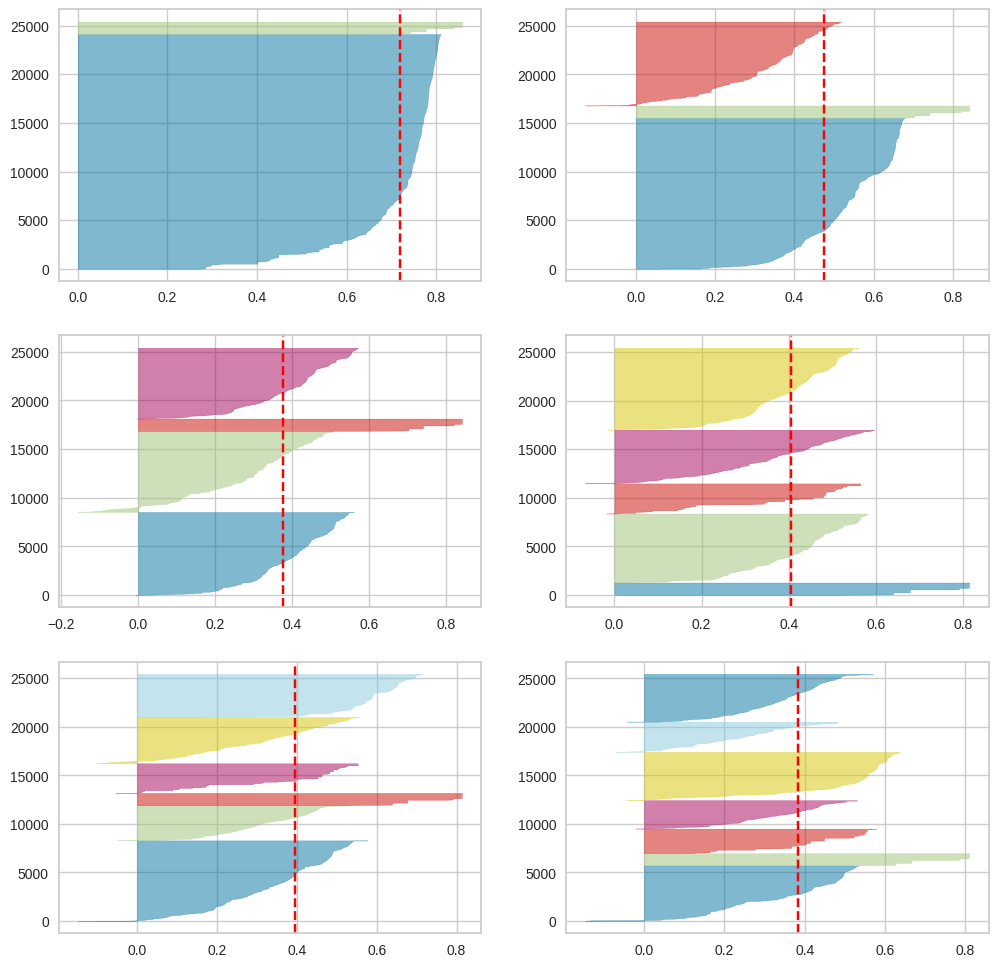

In [134]:
# silhoutte analysis
# this gives a perspective into the density and separation of the formed clusters
fig, ax = plt.subplots(3, 2, figsize=(12,12))
for k in [2, 3, 4, 5, 6, 7]:
    clusterer = KMeans(n_clusters = k, n_init='auto') # using KMeans algorithm

    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(clusterer, colors = 'yellowbrick', ax = ax[q-1][mod])
    visualizer.fit(df_pca_3)

    cluster_labels = clusterer.fit_predict(df_pca_3)
    silhouette_avg = silhouette_score(df_pca_3, cluster_labels)
    print(
        "For n_clusters =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )

> Based on the elbow method, I will consider k=3 and k=5 because the plot looks like an elbow at that point.

> Based on the silhouette analysis, I choose k=5. In k=3, the average score is better, but the size difference between green and blue area is too extreme.

## Clustering with SKLearn AgglomerativeClustering

In [135]:
agg_clust_model = AgglomerativeClustering(n_clusters=5)
clustering = agg_clust_model.fit_predict(df_pca_3)

In [180]:
# adding the clusters feature to the orignal dataframe
df_for_analysis["clusters"] = clustering

# Evaluation

In [181]:
len(df_for_analysis)

25388

In [182]:
df_for_analysis.sample()

,sales_id,concept,brand,menu_category,menu_name,quantity,user_id,user_tier_level,user_gender,customer_for_x_years,users_order_freq,menu_category_detail_full,province,clusters
16471,ab4a7358-7a85-4fcc-ab29-75cb4427d406,Resto,Kitchenette,FOOD,Pasta a la Carbonara (Chicken),1.0,0522344f-d086-4d53-9032-09391272fe82,Basic,F,1,29,FOOD - PASTA,Jabodetabek,1


In [183]:
# evaluation with silhouette score/coefficient
silhouette_score(df_pca_3, clustering)

0.40016472766649697

> The silhouette coefficient of the clusters formed is not that good, meaning that two data points in a different cluster might located too near.

In [184]:
# cluster distribution
fig = px.pie(df_for_analysis, names="clusters", width=400, height=400)
fig.update_layout(margin=dict(t=20, b=0))

> The clusters that is formed are not fairly distributed.

## Analysing segmented customer profile

I will analyzed the customer/user segment based on the `customer_for_x_years` and `users_order_freq` attributes.

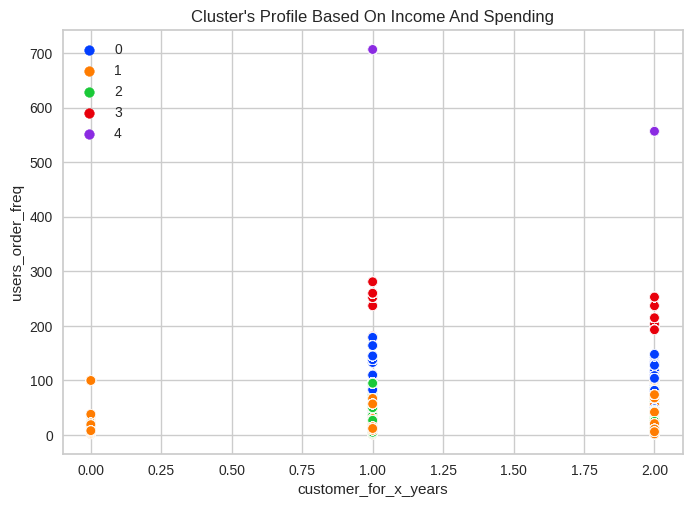

In [185]:
fig = sns.scatterplot(data=df_for_analysis,
                      x=df_for_analysis["customer_for_x_years"],
                      y=df_for_analysis["users_order_freq"],
                      hue=df_for_analysis["clusters"],
                      palette='bright')
fig.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

> Based on the plot above, I can infere that cluster:
- 0 is a user/customer that has made a decent number of order.
- 1 is a customer with most low order frequency, eventhough some of them has become a customer for 2 years. This cluster is the only one that contains user who only have been a customer for less than a year.
- 2 is more or less having the same quality as cluster 1
- 3 is a customer that has made a decent number of order. Higher than cluster 0 but very much lower then cluster 4.
- 4 is the most loyal customer because they had frequently placed an order and have become our customer for more than a year.

From the previouos inference, I will further analyze the customer in cluster 0, 3 and 4.

In [187]:
cluster_0 = df_for_analysis.query("clusters == 0")
len(cluster_0)

6019

In [188]:
cluster_3 = df_for_analysis.query("clusters == 3")
len(cluster_3)

2497

In [189]:
cluster_4 = df_for_analysis.query("clusters == 4")
len(cluster_4)

1264

### Segment 0 (cluster_0)

In [193]:
# count per brand
fig = px.histogram(cluster_0, y="brand", width=1200, height=600)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

> The most ordered brand is Osteria GIA, followed by Djournal and Pizza E Birra.

In [195]:
# count per user_tier_level
fig = px.histogram(cluster_0, y="user_tier_level", width=600, height=300)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

> Most of the customer in this cluster has a Gold tier member

In [196]:
# count per province
fig = px.histogram(cluster_0, y="province", width=600, height=300)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

> The customer in this cluster located in all of the provinces/areas that we served. But most of them must be lived in Jabodetabek area since the order was made there.

In [234]:
# count per menu_category_detail_full
temp = cluster_0.groupby(['menu_category_detail_full']).size().to_frame().sort_values([0], ascending = False).head(5).reset_index()
fig = px.histogram(temp, x=0, y='menu_category_detail_full', width=800, height=400)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

> The most ordered kind of menu turns out to be "BEVERAGE - BEVERAGE MODIFIER". On the other hand, the most ordered food-type menu is pasta.

### Segment 3 (cluster_3)

In [221]:
# count per brand
fig = px.histogram(cluster_3, y="brand")
fig.update_layout(yaxis={'categoryorder':'total ascending'})

> The most ordered brand is Djournal, followed by TPC and Kitchenette

In [223]:
# count per user_tier_level
fig = px.histogram(cluster_3, y="user_tier_level", width=600, height=300)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

> Most of the customer in this cluster has a Diamond tier member

In [215]:
# count per province
fig = px.histogram(cluster_3, y="province", width=600, height=300)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

> The customer in this cluster located in Jabodetabek, Bali & Jawa Barat

In [235]:
# count per menu_category_detail_full
temp = cluster_3.groupby(['menu_category_detail_full']).size().to_frame().sort_values([0], ascending = False).head(5).reset_index()
fig = px.histogram(temp, x=0, y='menu_category_detail_full', width=800, height=400)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

> The most ordered kind of menu is "BEVERAGE - ESPRESSO BASED", followed by "BEVERAGE - KOPI BATAVIA BY DJOURNAL"

### Segment 4 (cluster_4)

In [225]:
# count per brand
fig = px.histogram(cluster_4, y="brand")
fig.update_layout(yaxis={'categoryorder':'total ascending'})

> The most ordered brand is Djournal, followed by TPC and Kitchenette

In [226]:
# count per user_tier_level
fig = px.histogram(cluster_4, y="user_tier_level", width=600, height=300)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

> Most of the customer in this cluster has a Diamond tier member

In [227]:
# count per province
fig = px.histogram(cluster_4, y="province", width=600, height=300)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

> The customer in this cluster located in Jawa Barat & Jabodetabek. Surprisingly, there are more customer located in Jawa Barat (Bandung), rather than Jabodetabek

In [236]:
# count per menu_category_detail_full
temp = cluster_4.groupby(['menu_category_detail_full']).size().to_frame().sort_values([0], ascending = False).head(5).reset_index()
fig = px.histogram(temp, x=0, y='menu_category_detail_full', width=800, height=400)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

> The most ordered kind of menu is "BEVERAGE - ESPRESSO BASED". On the other hand, the most ordered food-type menu is pastry & sandwich

## Conclusion & Recommendation

I have segment the customers into 5 cluster. Based on how long they've been a customer and how frequently they've placed an order, I think there are 3 customer segmentations that need to be the focus of business:
- **Segment 0**, is a user/customer that has made a decent number of order
- **Segment 3**, is a customer that has made a decent number of order. Higher than segment 0 but very much lower then segment 4
- **Segment 4**, is the most loyal customer because they had frequently placed an order and have become our customer for more than a year.


The company should spend more time on treating those customer so that they loyality could be nurtured. Eventually, this will leads to more profit.

Based on the insight that I've analyzed from the 3 segments:
- Djournal is always on the top 3 most ordered brand. I will recommend the company to prioritized future campaign for this brand among other existing brands.
- Most of our loyal customer had ordered items from Jabodetabek & Jawa Barat outlets. I will recommend the company to push campaign in these provinces. On the other hand, the company could also run a campaign outside those provinces if they strategy is to attract new customer rather than retaining the old ones.
- Most of the loyal customer member tiering is Diamond and Gold. To further retain these customers, a certain promotional campaign or vouchers could be targeted to them. With this approach, company might also push those customer to reach Black tier (assume to be the highest tier).
- Turns out that some of the most ordered items from each cluster is just a "modifier". Without taking this into account, then there are "beverage - espresso based". This proven that our espresso coffee is the most selling items. Taking the "modifier", with respect to the "beverage", it can also be concluded that most of our loyal customer loves to modified their espresso so it could match their personal preferences.

One concrete actionable recommendation that I could give as an example is:
- Conducting a monthly campaign for Diamond, Gold, and Black tier user. Each of them will be given an X% discount voucher that they could redeemed when ordering espresso-based beverage at Djournal after placing at least Y order at any Legit outlets in a month. This campaign will only be available on Jabodetabek & Jawa Barat outlets.